In [81]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import linregress

from src.datasets.utils import get_dataset
from src.estimator.RR import RRClient
from src.estimator.SM import SMClient
from src.server import Server

In [82]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
N = 50
num_samples = np.random.randint(1000, 2000, size=N)
data = get_dataset('mnist', num_samples)

clients = []
for i in range(N):
    clients.append(RRClient(i, data[i], .0, lambda x: 1 / (1 + x)))
    
print('Start aggregating')
server = Server(clients)
W = server.aggregate(unbiased=True)
C = (W.T - W).sum(axis=0)

print('Compute gains')
gains = []
for i in range(N):
    gains.append(clients[i].gain(server.mtl[i]))

/home/echo/miniconda3/envs/incent-collab/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Start aggregating
Compute gains


<Axes: >

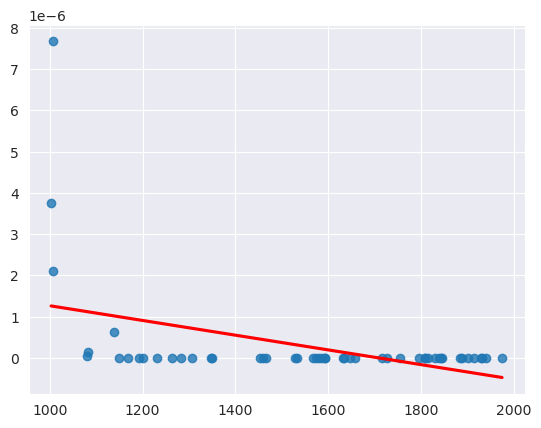

In [84]:
sns.regplot(x=server.vars, y=gains, ci=None, line_kws={"color": "red"})

In [85]:
C_bis = C - np.min(C)
C_bis = C_bis / np.max(C_bis)

array([0.40263704, 0.68472177, 0.63556706, 0.50121032, 0.        ,
       0.69115065, 0.44831887, 0.58561943, 0.52644486, 0.49314103,
       0.56261245, 0.59895839, 0.48178907, 0.43262426, 0.61647939,
       0.54510969, 0.55251273, 0.440995  , 0.17845738, 0.57008364,
       0.78949702, 0.44253326, 0.62080001, 0.35475858, 0.62428947,
       0.21667608, 0.50061569, 0.66242945, 1.        , 0.40305081,
       0.35968526, 0.66323461, 0.2197304 , 0.62415731, 0.77334461,
       0.55623851, 0.40449071, 0.87496804, 0.68955975, 0.62848765,
       0.50146728, 0.55234018, 0.52530585, 0.53301556, 0.52805783,
       0.66620131, 0.66303983, 0.06466408, 0.55487961, 0.70117599])

<Axes: >

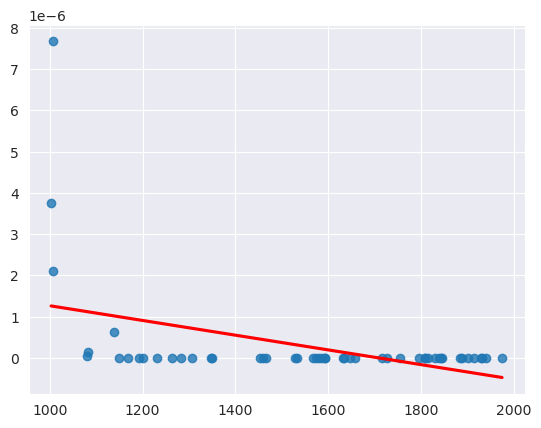

In [86]:
sns.regplot(x=C_bis, y=gains, ci=None, line_kws={"color": "red"})

# Practical Scalar Mean

In [168]:
N = 1000
num_samples = np.random.randint(1000, 10000, size=N)
MU = 50
SIGMA = 2
mus = np.random.normal(MU, SIGMA, size=N)

clients = []
for i in range(N):
    clients.append(SMClient(i, num_samples[i], mus[i], lambda x: 1 / (1 + x)))
    
print('Start aggregating')
server = Server(clients)
W = server.aggregate(unbiased=True)

print('Compute gains')
gains = []
for i in range(N):
    gains.append(clients[i].gain(server.mtl[i]))

Start aggregating
Compute gains


In [169]:
local_mse = [clients[i].mse(server.local[i]) for i in range(N)]
mtl_mse = [clients[i].mse(server.mtl[i]) for i in range(N)]

In [170]:
C = (W.T - W).sum(axis=0)
C_bis = C - np.min(C)
C_bis = C_bis / np.max(C_bis)

Slope: -4.4635374873617054e-07
Intercept: 0.004461931125275428


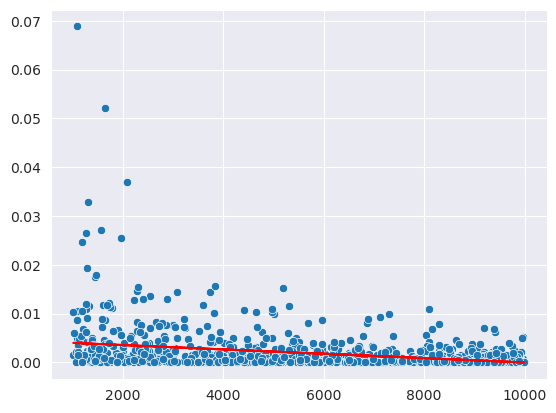

In [178]:
x, y = num_samples, local_mse
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()

Slope: 0.0005030853304817878
Intercept: -8.855503115585749e-07


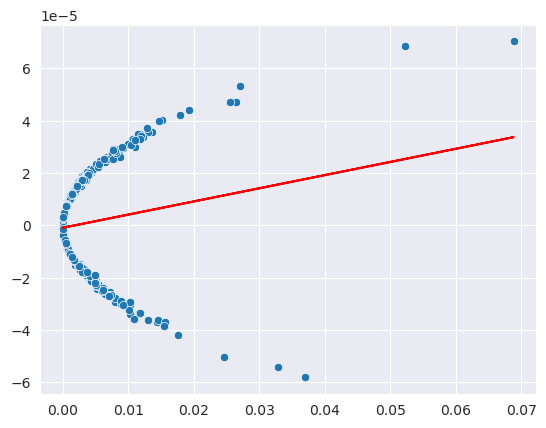

In [171]:
x, y = local_mse, gains
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()

Slope: 4.435478160386947e-06
Intercept: -2.9609762437104815e-06


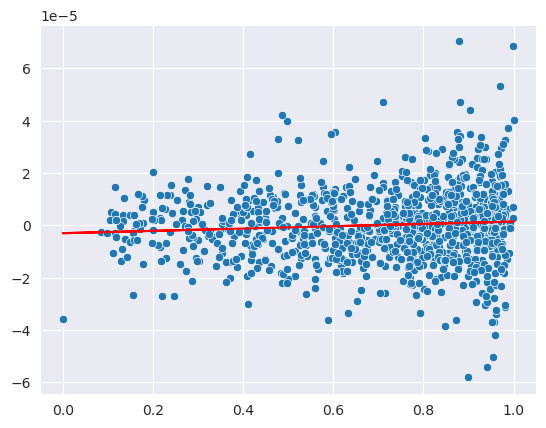

In [172]:
x, y = C_bis, gains
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()

## With C reg

In [173]:
def inc(id: int, W: np.ndarray) -> float:
    C = (W.T - W).sum(axis=0)
    C_bis = C - np.min(C)
    C_bis = C_bis / np.max(C_bis)
    return C_bis[id].item()

In [174]:
print('Start aggregating')
server = Server(clients)
W = server.aggregate(unbiased=True, inc=inc)

print('Compute gains')
gains_reg = []
for i in range(N):
    gains_reg.append(clients[i].gain(server.mtl[i]))

Start aggregating
Compute gains


In [175]:
local_mse_reg = [clients[i].mse(server.local[i]) for i in range(N)]
mtl_mse_reg = [clients[i].mse(server.mtl[i]) for i in range(N)]

Slope: -2.7158099563111
Intercept: -0.899828933126806


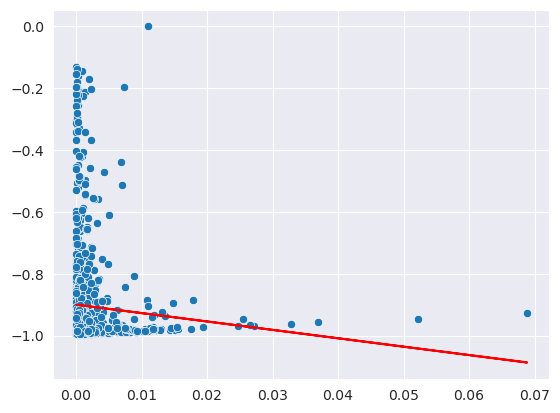

In [176]:
x, y = local_mse_reg, gains_reg
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()

Slope: -0.6016353751987478
Intercept: -0.4874424440531204


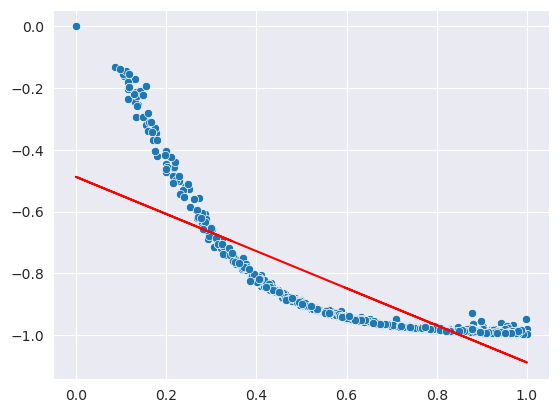

In [177]:
x, y = C_bis, gains_reg
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()

# Theoretical Exemple Scalar Mean

In [118]:
N = 10000
num_samples = np.random.randint(100, 1000, size=N)
MU = 50
SIGMA = 2
mus = np.random.normal(MU, SIGMA, size=N)
sigmas = np.random.random(size=N) * 2 + 2

V = np.eye(N) * sigmas
C = mus.reshape((N, 1)) @ mus.reshape(N, 1).T
W = C @ np.linalg.inv(C + V)

C = (W.T - W).sum(axis=0)
C_bis = C - np.min(C)
C_bis = C_bis / np.max(C_bis)
#C_bis = 1 - C_bis

utility = lambda x: 1 / (1 + x)
local_mse = sigmas ** 2 / num_samples
mtl_mse = mus ** 2 / (1 + (mus ** 2 / local_mse).sum())
gains = utility(mtl_mse) - utility(local_mse)

In [119]:
gains.shape, local_mse.shape, mtl_mse.shape, C.shape, C_bis.shape, W.shape

((10000,), (10000,), (10000,), (10000,), (10000,), (10000, 10000))

Slope: -5.7427086360609384e-08
Intercept: 1.4653675869093703e-06


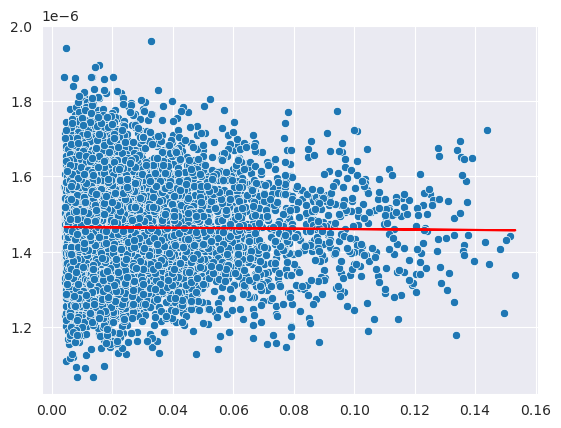

In [120]:
x, y = local_mse, mtl_mse
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()

Slope: 0.911656495604739
Intercept: 0.0011723802308396848


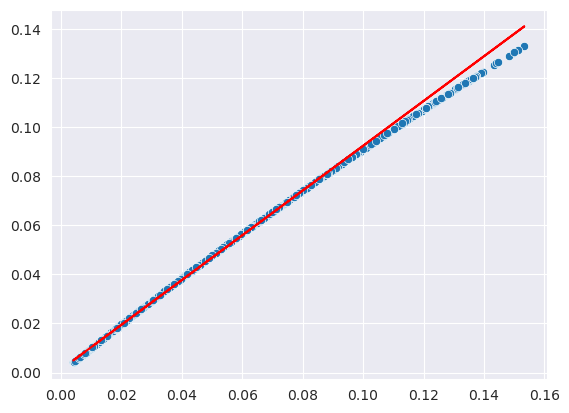

In [121]:
x, y = local_mse, gains
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()

Slope: 0.03179331785736144
Intercept: 0.003637316850597299


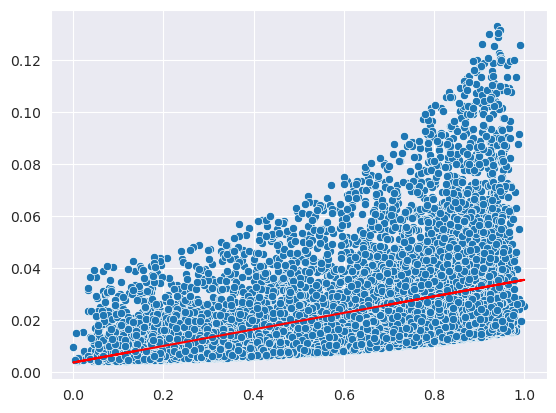

In [122]:
x, y = C_bis, gains
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()

## With C regularizer

Slope: 0.03179331785736144
Intercept: 0.003637316850597299


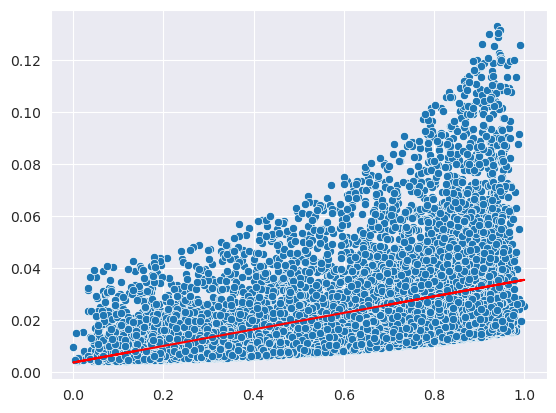

In [123]:
x, y = C_bis, gains
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()

Slope: 0.03414493165020538
Intercept: 0.0031513190119224453


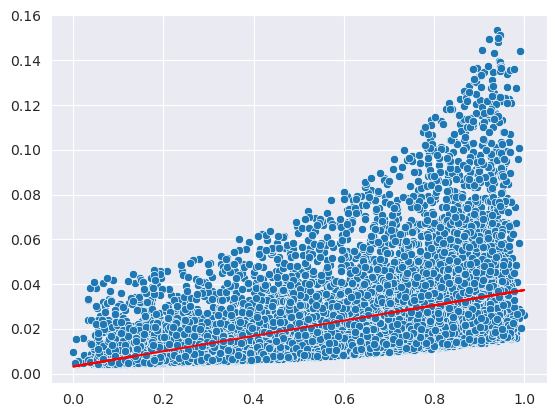

In [124]:
x, y = C_bis, local_mse
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()

In [125]:
mtl_mse = mus ** 2 / (1 + (mus ** 2 / local_mse).sum()) + C_bis * local_mse
gains_C_reg = utility(mtl_mse) - utility(local_mse)

Slope: -0.009070616240206579
Intercept: 0.012317773424767357


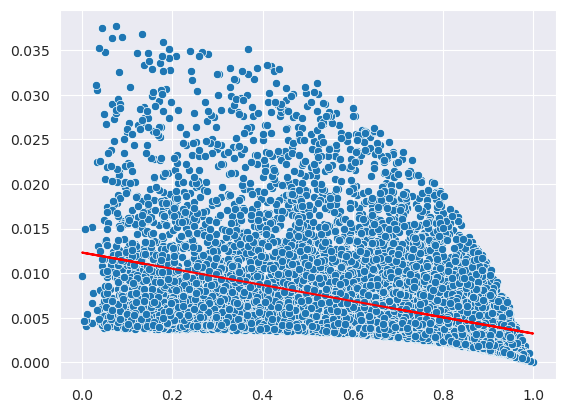

In [128]:
x, y = C_bis, gains_C_reg
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()

Slope: 0.1070935932884688
Intercept: 0.004170418639809799


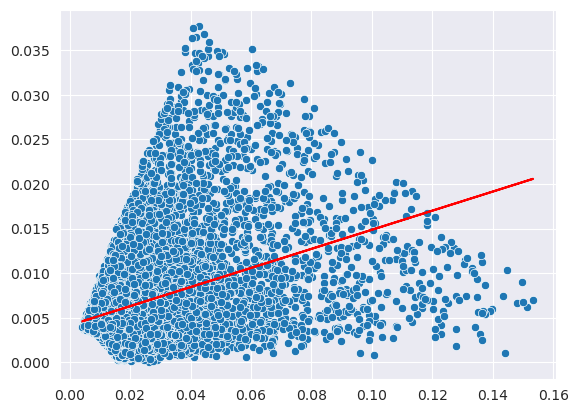

In [129]:
x, y = local_mse, gains_C_reg
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()